# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.83KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

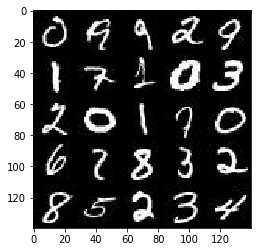

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

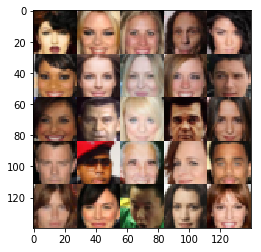

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import pickle as pkl

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    #creat real input images placeholder
    inputs_images = tf.placeholder(tf.float32, (None, image_width ,image_height , image_channels), name= 'inputs_images')
    #creat input z placeholder
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name= 'inputs_z')
    #creat learning_rate placeholder
    learn_rate = tf.placeholder(tf.float32)

    return inputs_images, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse= reuse):
        #input layer is 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides= 2, padding= 'same', kernel_initializer= tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(0.1 * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob= 0.5)
        #14*14*64 now
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides= 2, padding= 'same', kernel_initializer= tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training= True)
        relu2 = tf.maximum(0.1* bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob= 0.5)
        #7*7*128 now
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides= 2, padding= 'same', kernel_initializer= tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training= True)
        relu3 = tf.maximum(0.1 * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob= 0.5)
        #4 *4 *256 now
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        #first fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        if is_train:
            x1 = tf.nn.dropout(x1, keep_prob= 0.5)
        #reshape layer and start cnn
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training= is_train)
        x1 = tf.maximum(0.1* x1, x1)
        #4*4*512now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides= 2, padding= 'same')
        x2 = tf.layers.batch_normalization(x2, training= is_train)
        x2 = tf.maximum(0.1 * x2, x2)
        #8*8*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides= 2, padding= 'same')
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        x3 = tf.maximum(0.1 *x3, x3)
        #16*16*128
        
        x4 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides= 2, padding= 'same')
        #32*32*?
        
        logits = tf.image.resize_images(x4, (28,28))
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse= True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_real, labels= tf.ones_like(d_model_real) - 0.05))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, labels= tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, labels= tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #get weights and bias to update
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #apply optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    print_every=10
    show_every=100
    
    saver = tf.train.Saver()

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1
                
                #sample random noise for G
                batch_z = np.random.uniform(-1, 1, size= (batch_size, z_dim))
                
                #run optimizer
                _ = sess.run(d_opt, feed_dict = {input_real : batch_images, input_z : batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real : batch_images, input_z : batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real : batch_images, input_z : batch_z, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 4, input_z, channels, data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')
        print('The final generation is :')
        show_generator_output(sess, 4, input_z, channels, data_image_mode)
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 2.3823... Generator Loss: 0.3975
Epoch 0/2... Discriminator Loss: 3.0131... Generator Loss: 0.2271
Epoch 0/2... Discriminator Loss: 2.2974... Generator Loss: 0.7841
Epoch 0/2... Discriminator Loss: 2.8122... Generator Loss: 0.5758
Epoch 0/2... Discriminator Loss: 2.6441... Generator Loss: 0.8290
Epoch 0/2... Discriminator Loss: 2.6803... Generator Loss: 0.4721
Epoch 0/2... Discriminator Loss: 0.9207... Generator Loss: 1.1725
Epoch 0/2... Discriminator Loss: 1.8963... Generator Loss: 0.7638
Epoch 0/2... Discriminator Loss: 1.5145... Generator Loss: 0.8161
Epoch 0/2... Discriminator Loss: 1.9117... Generator Loss: 0.6102


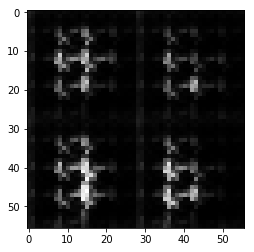

Epoch 0/2... Discriminator Loss: 1.1705... Generator Loss: 1.1952
Epoch 0/2... Discriminator Loss: 2.4997... Generator Loss: 0.8446
Epoch 0/2... Discriminator Loss: 1.4907... Generator Loss: 0.7203
Epoch 0/2... Discriminator Loss: 1.9780... Generator Loss: 0.7965
Epoch 0/2... Discriminator Loss: 1.4900... Generator Loss: 0.8991
Epoch 0/2... Discriminator Loss: 1.6404... Generator Loss: 0.6788
Epoch 0/2... Discriminator Loss: 1.7924... Generator Loss: 0.5717
Epoch 0/2... Discriminator Loss: 1.5545... Generator Loss: 0.6302
Epoch 0/2... Discriminator Loss: 1.2831... Generator Loss: 0.8775
Epoch 0/2... Discriminator Loss: 1.3647... Generator Loss: 1.0524


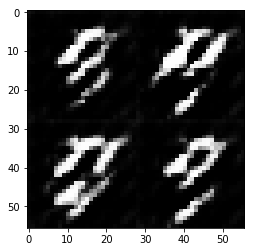

Epoch 0/2... Discriminator Loss: 1.4802... Generator Loss: 0.8295
Epoch 0/2... Discriminator Loss: 1.5123... Generator Loss: 0.8047
Epoch 0/2... Discriminator Loss: 1.7668... Generator Loss: 0.7412
Epoch 0/2... Discriminator Loss: 1.4931... Generator Loss: 0.8475
Epoch 0/2... Discriminator Loss: 1.5536... Generator Loss: 0.9864
Epoch 0/2... Discriminator Loss: 1.3530... Generator Loss: 0.8790
Epoch 0/2... Discriminator Loss: 1.6710... Generator Loss: 0.6702
Epoch 0/2... Discriminator Loss: 1.4580... Generator Loss: 0.7369
Epoch 0/2... Discriminator Loss: 1.5064... Generator Loss: 0.6624
Epoch 0/2... Discriminator Loss: 1.5364... Generator Loss: 0.7266


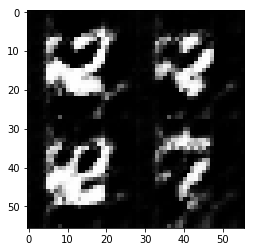

Epoch 0/2... Discriminator Loss: 1.3454... Generator Loss: 0.7672
Epoch 0/2... Discriminator Loss: 1.4732... Generator Loss: 0.7497
Epoch 0/2... Discriminator Loss: 1.6850... Generator Loss: 0.6718
Epoch 0/2... Discriminator Loss: 1.5164... Generator Loss: 0.6714
Epoch 0/2... Discriminator Loss: 1.4910... Generator Loss: 0.7616
Epoch 0/2... Discriminator Loss: 1.4095... Generator Loss: 1.0575
Epoch 0/2... Discriminator Loss: 1.4599... Generator Loss: 0.6813
Epoch 0/2... Discriminator Loss: 1.3118... Generator Loss: 0.7670
Epoch 0/2... Discriminator Loss: 1.2778... Generator Loss: 0.7886
Epoch 0/2... Discriminator Loss: 1.3951... Generator Loss: 0.7229


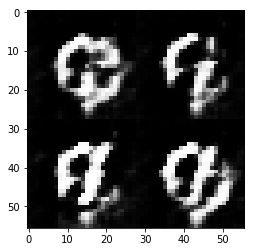

Epoch 0/2... Discriminator Loss: 1.3892... Generator Loss: 0.6747
Epoch 0/2... Discriminator Loss: 1.1968... Generator Loss: 0.8666
Epoch 0/2... Discriminator Loss: 1.4011... Generator Loss: 0.7740
Epoch 0/2... Discriminator Loss: 1.3780... Generator Loss: 0.9379
Epoch 0/2... Discriminator Loss: 1.4819... Generator Loss: 0.8178
Epoch 0/2... Discriminator Loss: 1.5368... Generator Loss: 0.7491
Epoch 0/2... Discriminator Loss: 1.2825... Generator Loss: 0.7390
Epoch 0/2... Discriminator Loss: 1.7917... Generator Loss: 0.5436
Epoch 0/2... Discriminator Loss: 1.3701... Generator Loss: 0.7816
Epoch 0/2... Discriminator Loss: 1.5258... Generator Loss: 0.7232


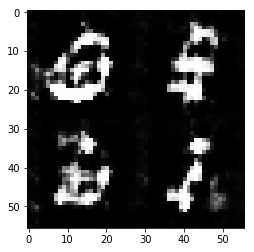

Epoch 0/2... Discriminator Loss: 1.5221... Generator Loss: 0.7061
Epoch 0/2... Discriminator Loss: 1.4424... Generator Loss: 0.8019
Epoch 0/2... Discriminator Loss: 1.1805... Generator Loss: 0.8441
Epoch 0/2... Discriminator Loss: 1.2885... Generator Loss: 0.8107
Epoch 0/2... Discriminator Loss: 1.2927... Generator Loss: 0.7910
Epoch 0/2... Discriminator Loss: 1.4276... Generator Loss: 0.6782
Epoch 0/2... Discriminator Loss: 1.3153... Generator Loss: 0.8226
Epoch 0/2... Discriminator Loss: 1.4282... Generator Loss: 0.6695
Epoch 0/2... Discriminator Loss: 1.4177... Generator Loss: 0.9291
Epoch 0/2... Discriminator Loss: 1.4950... Generator Loss: 0.6689


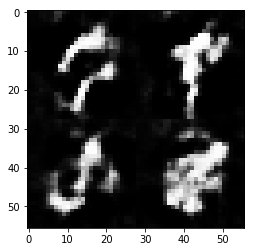

Epoch 0/2... Discriminator Loss: 1.3901... Generator Loss: 0.8085
Epoch 0/2... Discriminator Loss: 1.3530... Generator Loss: 0.7560
Epoch 0/2... Discriminator Loss: 1.5346... Generator Loss: 0.6249
Epoch 0/2... Discriminator Loss: 1.4573... Generator Loss: 0.6771
Epoch 0/2... Discriminator Loss: 1.4458... Generator Loss: 0.7435
Epoch 0/2... Discriminator Loss: 1.3780... Generator Loss: 0.5542
Epoch 0/2... Discriminator Loss: 1.2978... Generator Loss: 0.9394
Epoch 0/2... Discriminator Loss: 1.3334... Generator Loss: 0.7413
Epoch 0/2... Discriminator Loss: 1.4052... Generator Loss: 0.6593
Epoch 0/2... Discriminator Loss: 1.6014... Generator Loss: 0.5273


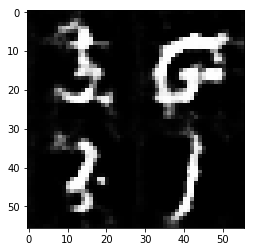

Epoch 0/2... Discriminator Loss: 1.5025... Generator Loss: 0.7233
Epoch 0/2... Discriminator Loss: 1.4187... Generator Loss: 0.6974
Epoch 0/2... Discriminator Loss: 1.4153... Generator Loss: 0.8388
Epoch 0/2... Discriminator Loss: 1.4045... Generator Loss: 0.7471
Epoch 0/2... Discriminator Loss: 1.4131... Generator Loss: 0.6599
Epoch 0/2... Discriminator Loss: 1.4554... Generator Loss: 0.5983
Epoch 0/2... Discriminator Loss: 1.3496... Generator Loss: 0.9673
Epoch 0/2... Discriminator Loss: 1.4117... Generator Loss: 0.7970
Epoch 0/2... Discriminator Loss: 1.2852... Generator Loss: 0.8142
Epoch 0/2... Discriminator Loss: 1.3206... Generator Loss: 0.8632


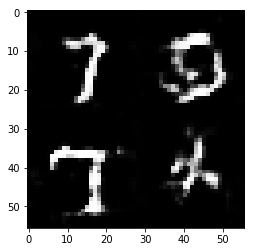

Epoch 0/2... Discriminator Loss: 1.4781... Generator Loss: 0.5569
Epoch 0/2... Discriminator Loss: 1.4076... Generator Loss: 0.5077
Epoch 0/2... Discriminator Loss: 1.4394... Generator Loss: 0.7898
Epoch 0/2... Discriminator Loss: 1.3637... Generator Loss: 0.9553
Epoch 0/2... Discriminator Loss: 1.3607... Generator Loss: 0.9028
Epoch 0/2... Discriminator Loss: 1.4819... Generator Loss: 0.9346
Epoch 0/2... Discriminator Loss: 1.4008... Generator Loss: 0.7906
Epoch 0/2... Discriminator Loss: 1.4101... Generator Loss: 0.8093
Epoch 0/2... Discriminator Loss: 1.3610... Generator Loss: 0.7275
Epoch 0/2... Discriminator Loss: 1.4557... Generator Loss: 0.7627


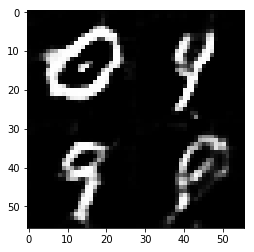

Epoch 0/2... Discriminator Loss: 1.3944... Generator Loss: 0.6633
Epoch 0/2... Discriminator Loss: 1.3399... Generator Loss: 0.6918
Epoch 0/2... Discriminator Loss: 1.4418... Generator Loss: 0.6502
Epoch 0/2... Discriminator Loss: 1.3743... Generator Loss: 0.7511
Epoch 0/2... Discriminator Loss: 1.5005... Generator Loss: 0.7265
Epoch 0/2... Discriminator Loss: 1.3988... Generator Loss: 0.7112
Epoch 0/2... Discriminator Loss: 1.2864... Generator Loss: 0.8807
Epoch 0/2... Discriminator Loss: 1.3738... Generator Loss: 0.6435
Epoch 0/2... Discriminator Loss: 1.2664... Generator Loss: 0.9994
Epoch 0/2... Discriminator Loss: 1.3652... Generator Loss: 0.6701


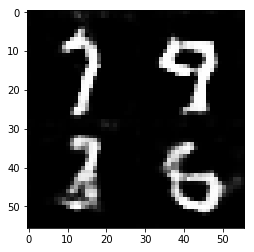

Epoch 0/2... Discriminator Loss: 1.5444... Generator Loss: 0.5784
Epoch 0/2... Discriminator Loss: 1.3919... Generator Loss: 0.8908
Epoch 0/2... Discriminator Loss: 1.4431... Generator Loss: 0.6513
Epoch 0/2... Discriminator Loss: 1.3170... Generator Loss: 0.9663
Epoch 0/2... Discriminator Loss: 1.5147... Generator Loss: 0.7378
Epoch 0/2... Discriminator Loss: 1.4989... Generator Loss: 0.6327
Epoch 0/2... Discriminator Loss: 1.2943... Generator Loss: 0.7272
Epoch 0/2... Discriminator Loss: 1.4197... Generator Loss: 0.9222
Epoch 0/2... Discriminator Loss: 1.3366... Generator Loss: 0.8578
Epoch 0/2... Discriminator Loss: 1.3649... Generator Loss: 0.8398


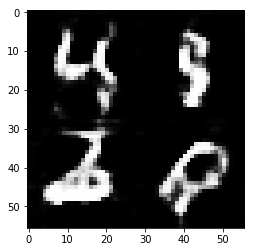

Epoch 0/2... Discriminator Loss: 1.4185... Generator Loss: 0.6087
Epoch 0/2... Discriminator Loss: 1.3798... Generator Loss: 0.7105
Epoch 0/2... Discriminator Loss: 1.2363... Generator Loss: 0.8359
Epoch 0/2... Discriminator Loss: 1.3584... Generator Loss: 0.6593
Epoch 0/2... Discriminator Loss: 1.4538... Generator Loss: 0.7593
Epoch 0/2... Discriminator Loss: 1.3451... Generator Loss: 0.6626
Epoch 0/2... Discriminator Loss: 1.2697... Generator Loss: 0.8277
Epoch 0/2... Discriminator Loss: 1.3982... Generator Loss: 0.7535
Epoch 0/2... Discriminator Loss: 1.3388... Generator Loss: 0.8243
Epoch 0/2... Discriminator Loss: 1.3882... Generator Loss: 0.7731


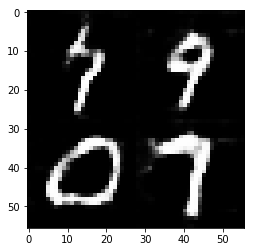

Epoch 0/2... Discriminator Loss: 1.3054... Generator Loss: 0.7432
Epoch 0/2... Discriminator Loss: 1.3955... Generator Loss: 0.7065
Epoch 0/2... Discriminator Loss: 1.2584... Generator Loss: 0.8686
Epoch 0/2... Discriminator Loss: 1.3412... Generator Loss: 0.6736
Epoch 0/2... Discriminator Loss: 1.4261... Generator Loss: 0.7314
Epoch 0/2... Discriminator Loss: 1.2545... Generator Loss: 0.7488
Epoch 0/2... Discriminator Loss: 1.4506... Generator Loss: 0.7997
Epoch 0/2... Discriminator Loss: 1.3934... Generator Loss: 0.9954
Epoch 0/2... Discriminator Loss: 1.3736... Generator Loss: 0.7067
Epoch 0/2... Discriminator Loss: 1.3458... Generator Loss: 0.9504


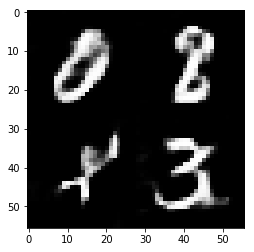

Epoch 0/2... Discriminator Loss: 1.2541... Generator Loss: 0.7729
Epoch 0/2... Discriminator Loss: 1.2802... Generator Loss: 0.9906
Epoch 0/2... Discriminator Loss: 1.4081... Generator Loss: 0.6453
Epoch 0/2... Discriminator Loss: 1.2279... Generator Loss: 0.6967
Epoch 0/2... Discriminator Loss: 1.3902... Generator Loss: 0.6632
Epoch 0/2... Discriminator Loss: 1.3590... Generator Loss: 0.6400
Epoch 0/2... Discriminator Loss: 1.4889... Generator Loss: 0.7685
Epoch 0/2... Discriminator Loss: 1.4463... Generator Loss: 0.6329
Epoch 0/2... Discriminator Loss: 1.3860... Generator Loss: 1.1859
Epoch 0/2... Discriminator Loss: 1.3923... Generator Loss: 0.8916


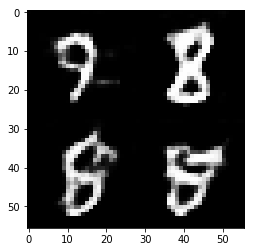

Epoch 0/2... Discriminator Loss: 1.4978... Generator Loss: 0.5472
Epoch 0/2... Discriminator Loss: 1.4694... Generator Loss: 0.8197
Epoch 0/2... Discriminator Loss: 1.3220... Generator Loss: 0.7346
Epoch 0/2... Discriminator Loss: 1.3540... Generator Loss: 0.5755
Epoch 0/2... Discriminator Loss: 1.4159... Generator Loss: 0.5254
Epoch 0/2... Discriminator Loss: 1.3803... Generator Loss: 0.9498
Epoch 0/2... Discriminator Loss: 1.4530... Generator Loss: 0.8465
Epoch 0/2... Discriminator Loss: 1.3590... Generator Loss: 0.8184
Epoch 0/2... Discriminator Loss: 1.2636... Generator Loss: 0.8623
Epoch 0/2... Discriminator Loss: 1.2273... Generator Loss: 0.8761


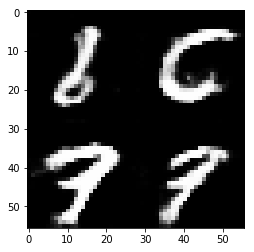

Epoch 0/2... Discriminator Loss: 1.3607... Generator Loss: 0.6962
Epoch 0/2... Discriminator Loss: 1.3156... Generator Loss: 0.9027
Epoch 0/2... Discriminator Loss: 1.3279... Generator Loss: 0.7848
Epoch 0/2... Discriminator Loss: 1.3049... Generator Loss: 0.6507
Epoch 0/2... Discriminator Loss: 1.3243... Generator Loss: 0.8051
Epoch 0/2... Discriminator Loss: 1.3500... Generator Loss: 0.7143
Epoch 0/2... Discriminator Loss: 1.3968... Generator Loss: 0.8399
Epoch 0/2... Discriminator Loss: 1.3691... Generator Loss: 0.9229
Epoch 0/2... Discriminator Loss: 1.2311... Generator Loss: 0.6595
Epoch 0/2... Discriminator Loss: 1.3065... Generator Loss: 0.6736


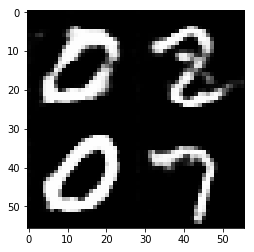

Epoch 0/2... Discriminator Loss: 1.2347... Generator Loss: 0.8878
Epoch 0/2... Discriminator Loss: 1.2956... Generator Loss: 0.9103
Epoch 0/2... Discriminator Loss: 1.2468... Generator Loss: 0.9720
Epoch 0/2... Discriminator Loss: 1.2084... Generator Loss: 0.9033
Epoch 0/2... Discriminator Loss: 1.2977... Generator Loss: 0.8168
Epoch 0/2... Discriminator Loss: 1.4136... Generator Loss: 0.9661
Epoch 0/2... Discriminator Loss: 1.1546... Generator Loss: 0.9017
Epoch 0/2... Discriminator Loss: 1.5268... Generator Loss: 0.6485
Epoch 0/2... Discriminator Loss: 1.2007... Generator Loss: 0.8444
Epoch 0/2... Discriminator Loss: 1.3902... Generator Loss: 1.0314


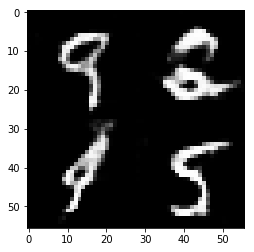

Epoch 0/2... Discriminator Loss: 1.1504... Generator Loss: 0.8508
Epoch 0/2... Discriminator Loss: 1.1944... Generator Loss: 0.8066
Epoch 0/2... Discriminator Loss: 1.4321... Generator Loss: 0.7925
Epoch 0/2... Discriminator Loss: 1.3430... Generator Loss: 0.9659
Epoch 0/2... Discriminator Loss: 1.3206... Generator Loss: 0.7570
Epoch 0/2... Discriminator Loss: 1.2572... Generator Loss: 0.7038
Epoch 0/2... Discriminator Loss: 1.4304... Generator Loss: 0.5744
Epoch 0/2... Discriminator Loss: 1.2914... Generator Loss: 0.8189
Epoch 0/2... Discriminator Loss: 1.2055... Generator Loss: 0.9960
Epoch 0/2... Discriminator Loss: 1.2607... Generator Loss: 0.8728


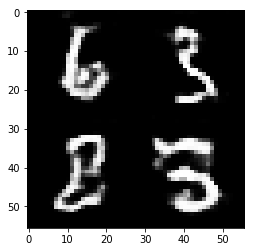

Epoch 0/2... Discriminator Loss: 1.4355... Generator Loss: 1.1503
Epoch 0/2... Discriminator Loss: 1.3650... Generator Loss: 0.7632
Epoch 0/2... Discriminator Loss: 1.2784... Generator Loss: 0.7946
Epoch 0/2... Discriminator Loss: 1.2341... Generator Loss: 0.9287
Epoch 0/2... Discriminator Loss: 1.3083... Generator Loss: 0.9181
Epoch 0/2... Discriminator Loss: 1.4522... Generator Loss: 0.6921
Epoch 0/2... Discriminator Loss: 1.2396... Generator Loss: 0.9707
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.8449
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.8365


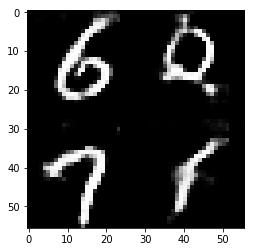

Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 1.6338
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.4947
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 1.0819
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 1.0282
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 0.6908


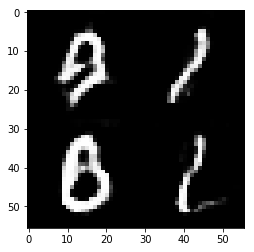

Epoch 1/2... Discriminator Loss: 1.2153... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.9281
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 0.7764
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.9865
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.9900
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.2225... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.6397
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 0.9900


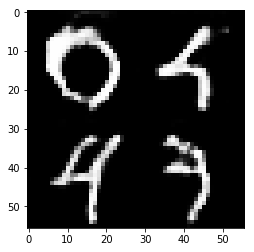

Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 1.1421
Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.5414
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.7474
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 0.6819
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.8490


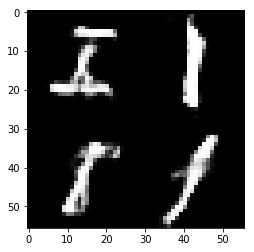

Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.9441
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.9831
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.7039
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 1.0261
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 1.2369
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 1.1743
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 0.7672
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 1.1019
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 0.8938


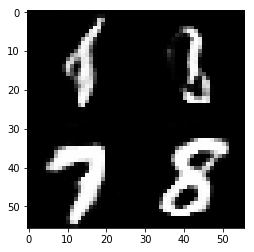

Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.6015
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 1.0333
Epoch 1/2... Discriminator Loss: 1.4924... Generator Loss: 1.0022
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.6866
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 1.0078
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 1.3393


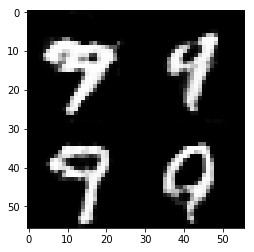

Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 1.0660
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.9193
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 0.9044
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.9216
Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 1.1126
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.7672
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 0.9651
Epoch 1/2... Discriminator Loss: 1.4755... Generator Loss: 0.3920
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 1.2138


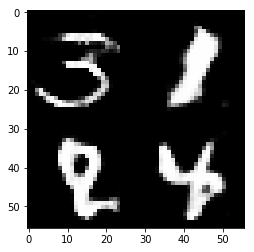

Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.9811
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.7309
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 1.0209
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 1.2922
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.4640
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 0.5974
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.8390


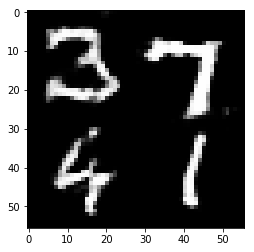

Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 1.1889
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 1.1803
Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 0.9412
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 0.8949
Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 1.1917


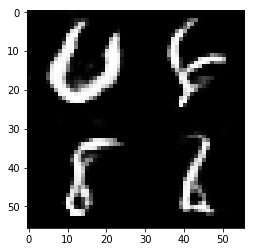

Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.2694... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.9810
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.9729
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.8552
Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 0.7080
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.9641
Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 0.9564


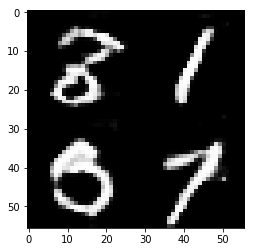

Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.8196
Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 0.8049
Epoch 1/2... Discriminator Loss: 1.2520... Generator Loss: 0.9151
Epoch 1/2... Discriminator Loss: 1.4533... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 0.9406
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 1.0640
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.7965


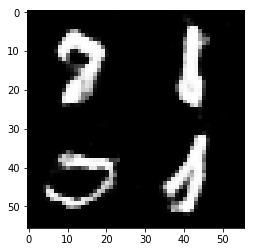

Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 1.0150
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 1.1809
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 0.9281
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 1.0996
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 1.2414
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 1.1553
Epoch 1/2... Discriminator Loss: 1.2643... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.8789
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 1.1162
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.6888


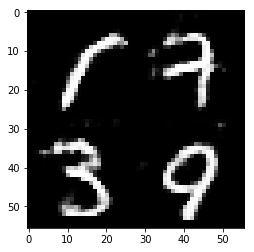

Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 0.8561
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 1.4120
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.7690
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 1.1581
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 1.2344
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 0.7515
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.6230


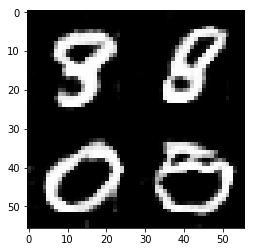

Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 0.8097
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 0.8338
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 1.0956
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 0.5846
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 1.6397
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.8593
Epoch 1/2... Discriminator Loss: 1.4482... Generator Loss: 0.9822
Epoch 1/2... Discriminator Loss: 1.0101... Generator Loss: 1.1668


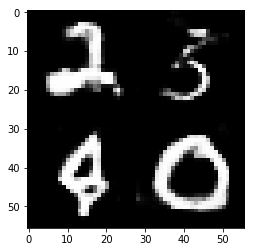

Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 1.3958
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 1.2661
Epoch 1/2... Discriminator Loss: 0.9805... Generator Loss: 0.6073
Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 0.9340
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.4655
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.9717
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 1.1661... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 1.3276


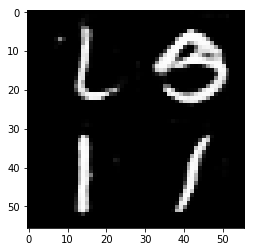

Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 1.0564
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 0.8937
Epoch 1/2... Discriminator Loss: 1.2297... Generator Loss: 0.9422
Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 0.8687
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 1.0373
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 0.9277
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 1.0874
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 1.0808


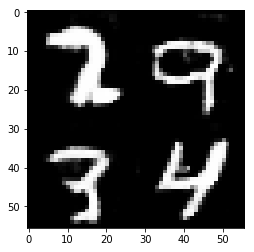

Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 1.2407
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.6772
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.6622
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.9038
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.8822


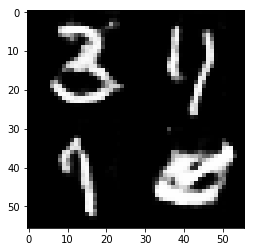

Epoch 1/2... Discriminator Loss: 1.2643... Generator Loss: 1.2940
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 1.1432
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.9574
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.0518... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 0.8047


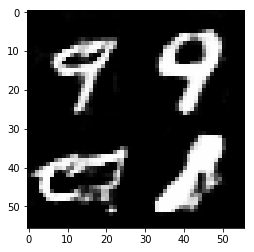

Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 1.3998
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 1.4228
Epoch 1/2... Discriminator Loss: 1.1691... Generator Loss: 0.9573
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 1.6507
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 1.3348
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.9405
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 0.9637


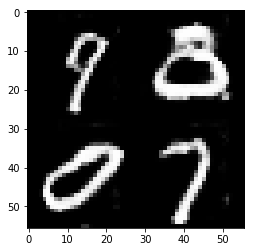

Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 0.6292
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 1.9148
Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.0088... Generator Loss: 0.9451
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 2.0306
The final generation is :


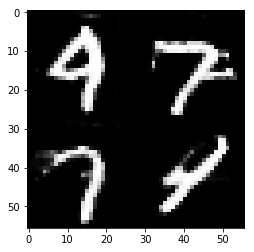

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    #tf.reset_default_graph()
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 2.7946... Generator Loss: 0.6304
Epoch 0/1... Discriminator Loss: 4.0503... Generator Loss: 0.4024
Epoch 0/1... Discriminator Loss: 3.3284... Generator Loss: 0.4277
Epoch 0/1... Discriminator Loss: 1.8889... Generator Loss: 0.5325
Epoch 0/1... Discriminator Loss: 2.5527... Generator Loss: 0.3594
Epoch 0/1... Discriminator Loss: 2.0701... Generator Loss: 0.6216
Epoch 0/1... Discriminator Loss: 1.6759... Generator Loss: 0.5232
Epoch 0/1... Discriminator Loss: 1.7359... Generator Loss: 0.5568
Epoch 0/1... Discriminator Loss: 1.9198... Generator Loss: 0.5949
Epoch 0/1... Discriminator Loss: 1.4787... Generator Loss: 0.6769


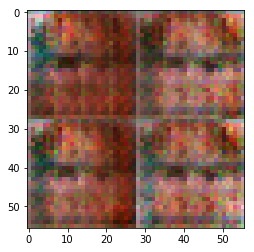

Epoch 0/1... Discriminator Loss: 1.3081... Generator Loss: 0.7492
Epoch 0/1... Discriminator Loss: 1.5766... Generator Loss: 0.5666
Epoch 0/1... Discriminator Loss: 1.4942... Generator Loss: 0.6794
Epoch 0/1... Discriminator Loss: 1.4192... Generator Loss: 0.7301
Epoch 0/1... Discriminator Loss: 1.5105... Generator Loss: 0.6999
Epoch 0/1... Discriminator Loss: 1.6312... Generator Loss: 0.5722
Epoch 0/1... Discriminator Loss: 1.9255... Generator Loss: 0.6519
Epoch 0/1... Discriminator Loss: 1.4544... Generator Loss: 0.7224
Epoch 0/1... Discriminator Loss: 1.4643... Generator Loss: 0.7516
Epoch 0/1... Discriminator Loss: 1.7922... Generator Loss: 0.5444


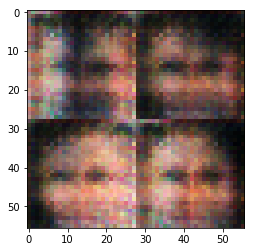

Epoch 0/1... Discriminator Loss: 1.4803... Generator Loss: 0.7485
Epoch 0/1... Discriminator Loss: 1.4867... Generator Loss: 0.6579
Epoch 0/1... Discriminator Loss: 1.5005... Generator Loss: 0.6975
Epoch 0/1... Discriminator Loss: 1.6495... Generator Loss: 0.6604
Epoch 0/1... Discriminator Loss: 1.3852... Generator Loss: 0.7702
Epoch 0/1... Discriminator Loss: 1.5301... Generator Loss: 0.6076
Epoch 0/1... Discriminator Loss: 1.5124... Generator Loss: 0.6477
Epoch 0/1... Discriminator Loss: 1.4843... Generator Loss: 0.7224
Epoch 0/1... Discriminator Loss: 1.5181... Generator Loss: 0.6575
Epoch 0/1... Discriminator Loss: 1.6794... Generator Loss: 0.5231


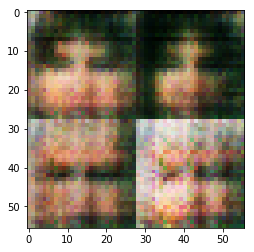

Epoch 0/1... Discriminator Loss: 1.5761... Generator Loss: 0.6445
Epoch 0/1... Discriminator Loss: 1.3848... Generator Loss: 0.7034
Epoch 0/1... Discriminator Loss: 1.5709... Generator Loss: 0.6553
Epoch 0/1... Discriminator Loss: 1.4538... Generator Loss: 0.7895
Epoch 0/1... Discriminator Loss: 1.4875... Generator Loss: 0.6677
Epoch 0/1... Discriminator Loss: 1.4802... Generator Loss: 0.7970
Epoch 0/1... Discriminator Loss: 1.4307... Generator Loss: 0.7337
Epoch 0/1... Discriminator Loss: 1.4190... Generator Loss: 0.6755
Epoch 0/1... Discriminator Loss: 1.4672... Generator Loss: 0.7254
Epoch 0/1... Discriminator Loss: 1.5332... Generator Loss: 0.6007


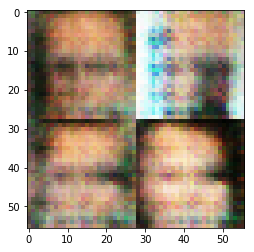

Epoch 0/1... Discriminator Loss: 1.4882... Generator Loss: 0.6600
Epoch 0/1... Discriminator Loss: 1.5220... Generator Loss: 0.7604
Epoch 0/1... Discriminator Loss: 1.5981... Generator Loss: 0.6266
Epoch 0/1... Discriminator Loss: 1.3515... Generator Loss: 0.6874
Epoch 0/1... Discriminator Loss: 1.4897... Generator Loss: 0.5673
Epoch 0/1... Discriminator Loss: 1.5021... Generator Loss: 0.5537
Epoch 0/1... Discriminator Loss: 1.5419... Generator Loss: 0.6555
Epoch 0/1... Discriminator Loss: 1.4835... Generator Loss: 0.7727
Epoch 0/1... Discriminator Loss: 1.5240... Generator Loss: 0.7300
Epoch 0/1... Discriminator Loss: 1.5260... Generator Loss: 0.9620


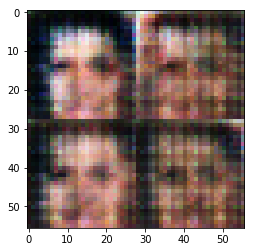

Epoch 0/1... Discriminator Loss: 1.5801... Generator Loss: 0.6342
Epoch 0/1... Discriminator Loss: 1.3734... Generator Loss: 0.6998
Epoch 0/1... Discriminator Loss: 1.4062... Generator Loss: 0.7094
Epoch 0/1... Discriminator Loss: 1.4968... Generator Loss: 0.7439
Epoch 0/1... Discriminator Loss: 1.4325... Generator Loss: 0.7190
Epoch 0/1... Discriminator Loss: 1.4853... Generator Loss: 0.6104
Epoch 0/1... Discriminator Loss: 1.4394... Generator Loss: 0.7480
Epoch 0/1... Discriminator Loss: 1.4989... Generator Loss: 0.6212
Epoch 0/1... Discriminator Loss: 1.4233... Generator Loss: 0.7031
Epoch 0/1... Discriminator Loss: 1.4342... Generator Loss: 0.7340


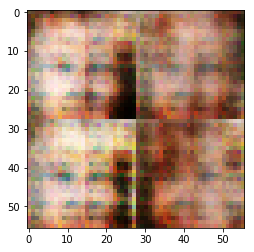

Epoch 0/1... Discriminator Loss: 1.5951... Generator Loss: 0.5384
Epoch 0/1... Discriminator Loss: 1.3646... Generator Loss: 0.6995
Epoch 0/1... Discriminator Loss: 1.4897... Generator Loss: 0.6792
Epoch 0/1... Discriminator Loss: 1.4473... Generator Loss: 0.5516
Epoch 0/1... Discriminator Loss: 1.4783... Generator Loss: 0.7623
Epoch 0/1... Discriminator Loss: 1.4059... Generator Loss: 0.6234
Epoch 0/1... Discriminator Loss: 1.4770... Generator Loss: 0.7194
Epoch 0/1... Discriminator Loss: 1.4275... Generator Loss: 0.6697
Epoch 0/1... Discriminator Loss: 1.4056... Generator Loss: 0.8637
Epoch 0/1... Discriminator Loss: 1.5164... Generator Loss: 0.6832


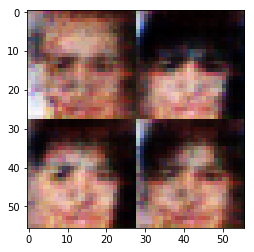

Epoch 0/1... Discriminator Loss: 1.5224... Generator Loss: 0.6396
Epoch 0/1... Discriminator Loss: 1.4384... Generator Loss: 0.6135
Epoch 0/1... Discriminator Loss: 1.4467... Generator Loss: 0.7248
Epoch 0/1... Discriminator Loss: 1.4083... Generator Loss: 0.7510
Epoch 0/1... Discriminator Loss: 1.4967... Generator Loss: 0.6671
Epoch 0/1... Discriminator Loss: 1.3735... Generator Loss: 0.6703
Epoch 0/1... Discriminator Loss: 1.4327... Generator Loss: 0.6782
Epoch 0/1... Discriminator Loss: 1.3778... Generator Loss: 0.8699
Epoch 0/1... Discriminator Loss: 1.4408... Generator Loss: 0.6817
Epoch 0/1... Discriminator Loss: 1.4297... Generator Loss: 0.7048


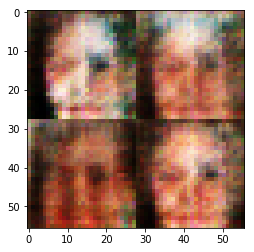

Epoch 0/1... Discriminator Loss: 1.4437... Generator Loss: 0.6135
Epoch 0/1... Discriminator Loss: 1.5048... Generator Loss: 0.6408
Epoch 0/1... Discriminator Loss: 1.5087... Generator Loss: 0.6389
Epoch 0/1... Discriminator Loss: 1.5448... Generator Loss: 0.6243
Epoch 0/1... Discriminator Loss: 1.4750... Generator Loss: 0.7443
Epoch 0/1... Discriminator Loss: 1.3949... Generator Loss: 0.7967
Epoch 0/1... Discriminator Loss: 1.4626... Generator Loss: 0.6958
Epoch 0/1... Discriminator Loss: 1.4909... Generator Loss: 0.6963
Epoch 0/1... Discriminator Loss: 1.4668... Generator Loss: 0.7989
Epoch 0/1... Discriminator Loss: 1.3691... Generator Loss: 0.6745


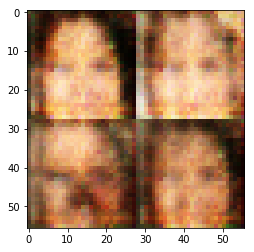

Epoch 0/1... Discriminator Loss: 1.4919... Generator Loss: 0.7727
Epoch 0/1... Discriminator Loss: 1.4994... Generator Loss: 0.6919
Epoch 0/1... Discriminator Loss: 1.3743... Generator Loss: 0.7056
Epoch 0/1... Discriminator Loss: 1.4156... Generator Loss: 0.7286
Epoch 0/1... Discriminator Loss: 1.5097... Generator Loss: 0.5603
Epoch 0/1... Discriminator Loss: 1.4188... Generator Loss: 0.9000
Epoch 0/1... Discriminator Loss: 1.3464... Generator Loss: 0.6655
Epoch 0/1... Discriminator Loss: 1.5235... Generator Loss: 0.7267
Epoch 0/1... Discriminator Loss: 1.4160... Generator Loss: 0.7261
Epoch 0/1... Discriminator Loss: 1.4581... Generator Loss: 0.6890


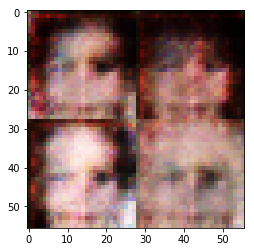

Epoch 0/1... Discriminator Loss: 1.4258... Generator Loss: 0.6523
Epoch 0/1... Discriminator Loss: 1.5337... Generator Loss: 0.8935
Epoch 0/1... Discriminator Loss: 1.4127... Generator Loss: 0.9131
Epoch 0/1... Discriminator Loss: 1.4227... Generator Loss: 0.5494
Epoch 0/1... Discriminator Loss: 1.4512... Generator Loss: 0.6310
Epoch 0/1... Discriminator Loss: 1.5138... Generator Loss: 0.6963
Epoch 0/1... Discriminator Loss: 1.4544... Generator Loss: 0.6194
Epoch 0/1... Discriminator Loss: 1.3755... Generator Loss: 0.8390
Epoch 0/1... Discriminator Loss: 1.4128... Generator Loss: 0.7358
Epoch 0/1... Discriminator Loss: 1.4100... Generator Loss: 0.7897


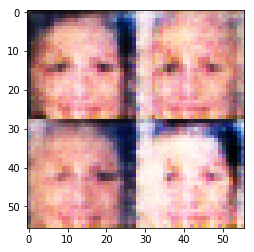

Epoch 0/1... Discriminator Loss: 1.3876... Generator Loss: 0.6864
Epoch 0/1... Discriminator Loss: 1.4506... Generator Loss: 0.7302
Epoch 0/1... Discriminator Loss: 1.4264... Generator Loss: 0.7313
Epoch 0/1... Discriminator Loss: 1.4306... Generator Loss: 0.7316
Epoch 0/1... Discriminator Loss: 1.4359... Generator Loss: 0.7720
Epoch 0/1... Discriminator Loss: 1.3834... Generator Loss: 0.9044
Epoch 0/1... Discriminator Loss: 1.3471... Generator Loss: 0.8050
Epoch 0/1... Discriminator Loss: 1.5561... Generator Loss: 0.7470
Epoch 0/1... Discriminator Loss: 1.4174... Generator Loss: 0.6461
Epoch 0/1... Discriminator Loss: 1.6253... Generator Loss: 0.5892


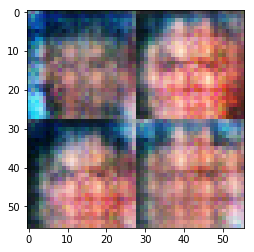

Epoch 0/1... Discriminator Loss: 1.4691... Generator Loss: 0.7014
Epoch 0/1... Discriminator Loss: 1.4595... Generator Loss: 0.6338
Epoch 0/1... Discriminator Loss: 1.4945... Generator Loss: 0.7396
Epoch 0/1... Discriminator Loss: 1.4256... Generator Loss: 0.8566
Epoch 0/1... Discriminator Loss: 1.4468... Generator Loss: 0.8286
Epoch 0/1... Discriminator Loss: 1.3885... Generator Loss: 0.7665
Epoch 0/1... Discriminator Loss: 1.3848... Generator Loss: 0.7696
Epoch 0/1... Discriminator Loss: 1.4576... Generator Loss: 0.5959
Epoch 0/1... Discriminator Loss: 1.3621... Generator Loss: 0.6800
Epoch 0/1... Discriminator Loss: 1.4927... Generator Loss: 0.7932


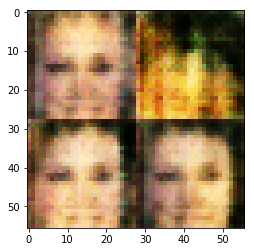

Epoch 0/1... Discriminator Loss: 1.4255... Generator Loss: 0.6929
Epoch 0/1... Discriminator Loss: 1.3954... Generator Loss: 0.6771
Epoch 0/1... Discriminator Loss: 1.6484... Generator Loss: 0.4397
Epoch 0/1... Discriminator Loss: 1.4455... Generator Loss: 0.7065
Epoch 0/1... Discriminator Loss: 1.3908... Generator Loss: 0.7198
Epoch 0/1... Discriminator Loss: 1.4373... Generator Loss: 0.7022
Epoch 0/1... Discriminator Loss: 1.3935... Generator Loss: 0.7973
Epoch 0/1... Discriminator Loss: 1.4104... Generator Loss: 0.6108
Epoch 0/1... Discriminator Loss: 1.4371... Generator Loss: 0.6618
Epoch 0/1... Discriminator Loss: 1.4424... Generator Loss: 0.6947


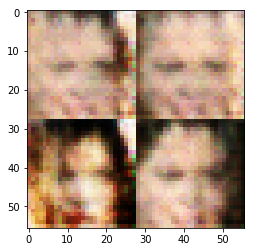

Epoch 0/1... Discriminator Loss: 1.3937... Generator Loss: 0.7077
Epoch 0/1... Discriminator Loss: 1.4197... Generator Loss: 0.7393
Epoch 0/1... Discriminator Loss: 1.4320... Generator Loss: 0.8477
Epoch 0/1... Discriminator Loss: 1.3784... Generator Loss: 0.6852
Epoch 0/1... Discriminator Loss: 1.4290... Generator Loss: 0.8187
Epoch 0/1... Discriminator Loss: 1.4358... Generator Loss: 0.8122
Epoch 0/1... Discriminator Loss: 1.4143... Generator Loss: 0.8268
Epoch 0/1... Discriminator Loss: 1.4190... Generator Loss: 0.7282
Epoch 0/1... Discriminator Loss: 1.4940... Generator Loss: 0.5052
Epoch 0/1... Discriminator Loss: 1.4372... Generator Loss: 0.7778


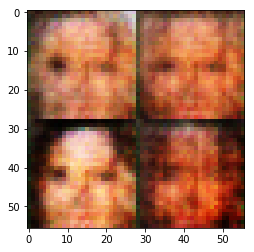

Epoch 0/1... Discriminator Loss: 1.5178... Generator Loss: 0.7446
Epoch 0/1... Discriminator Loss: 1.4535... Generator Loss: 0.7969
Epoch 0/1... Discriminator Loss: 1.5001... Generator Loss: 0.7442
Epoch 0/1... Discriminator Loss: 1.4631... Generator Loss: 0.7468
Epoch 0/1... Discriminator Loss: 1.4875... Generator Loss: 0.5836
Epoch 0/1... Discriminator Loss: 1.4930... Generator Loss: 0.6713
Epoch 0/1... Discriminator Loss: 1.4123... Generator Loss: 0.8089
Epoch 0/1... Discriminator Loss: 1.4805... Generator Loss: 0.6786
Epoch 0/1... Discriminator Loss: 1.4302... Generator Loss: 0.7331
Epoch 0/1... Discriminator Loss: 1.4981... Generator Loss: 0.7716


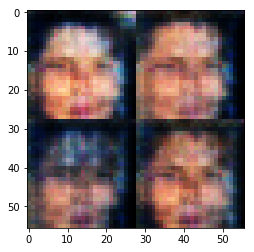

Epoch 0/1... Discriminator Loss: 1.4404... Generator Loss: 0.7353
Epoch 0/1... Discriminator Loss: 1.4223... Generator Loss: 0.7026
Epoch 0/1... Discriminator Loss: 1.4632... Generator Loss: 0.6861
Epoch 0/1... Discriminator Loss: 1.5090... Generator Loss: 0.6243
Epoch 0/1... Discriminator Loss: 1.4462... Generator Loss: 0.8387
Epoch 0/1... Discriminator Loss: 1.3690... Generator Loss: 0.7152
Epoch 0/1... Discriminator Loss: 1.4797... Generator Loss: 0.8606
Epoch 0/1... Discriminator Loss: 1.4294... Generator Loss: 0.7099
Epoch 0/1... Discriminator Loss: 1.4093... Generator Loss: 0.7758
Epoch 0/1... Discriminator Loss: 1.4801... Generator Loss: 0.7550


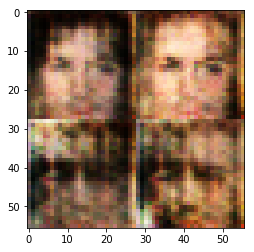

Epoch 0/1... Discriminator Loss: 1.4130... Generator Loss: 0.7687
Epoch 0/1... Discriminator Loss: 1.4516... Generator Loss: 0.6859
Epoch 0/1... Discriminator Loss: 1.4093... Generator Loss: 0.7745
Epoch 0/1... Discriminator Loss: 1.4268... Generator Loss: 0.6754
Epoch 0/1... Discriminator Loss: 1.4110... Generator Loss: 0.8349
Epoch 0/1... Discriminator Loss: 1.4318... Generator Loss: 0.6523
Epoch 0/1... Discriminator Loss: 1.4139... Generator Loss: 0.7795
Epoch 0/1... Discriminator Loss: 1.4587... Generator Loss: 0.6628
Epoch 0/1... Discriminator Loss: 1.3737... Generator Loss: 0.7781
Epoch 0/1... Discriminator Loss: 1.4414... Generator Loss: 0.6273


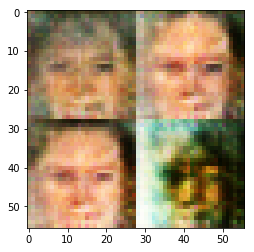

Epoch 0/1... Discriminator Loss: 1.3659... Generator Loss: 0.7444
Epoch 0/1... Discriminator Loss: 1.5195... Generator Loss: 0.5617
Epoch 0/1... Discriminator Loss: 1.4506... Generator Loss: 0.7322
Epoch 0/1... Discriminator Loss: 1.3898... Generator Loss: 0.7332
Epoch 0/1... Discriminator Loss: 1.4279... Generator Loss: 0.6485
Epoch 0/1... Discriminator Loss: 1.4219... Generator Loss: 0.7821
Epoch 0/1... Discriminator Loss: 1.4082... Generator Loss: 0.6868
Epoch 0/1... Discriminator Loss: 1.4300... Generator Loss: 0.7531
Epoch 0/1... Discriminator Loss: 1.4905... Generator Loss: 0.8167
Epoch 0/1... Discriminator Loss: 1.4049... Generator Loss: 0.8132


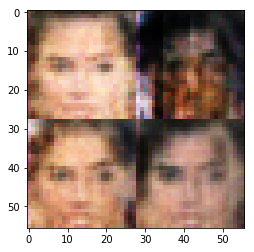

Epoch 0/1... Discriminator Loss: 1.4266... Generator Loss: 0.6792
Epoch 0/1... Discriminator Loss: 1.4212... Generator Loss: 0.7808
Epoch 0/1... Discriminator Loss: 1.3783... Generator Loss: 0.6685
Epoch 0/1... Discriminator Loss: 1.3718... Generator Loss: 0.6814
Epoch 0/1... Discriminator Loss: 1.4003... Generator Loss: 0.7555
Epoch 0/1... Discriminator Loss: 1.4107... Generator Loss: 0.7504
Epoch 0/1... Discriminator Loss: 1.3952... Generator Loss: 0.7876
Epoch 0/1... Discriminator Loss: 1.4895... Generator Loss: 0.7692
Epoch 0/1... Discriminator Loss: 1.4313... Generator Loss: 0.7009
Epoch 0/1... Discriminator Loss: 1.3814... Generator Loss: 0.6675


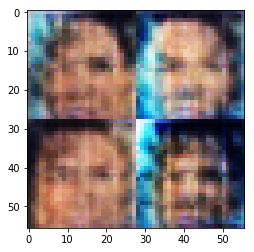

Epoch 0/1... Discriminator Loss: 1.3343... Generator Loss: 0.7289
Epoch 0/1... Discriminator Loss: 1.4148... Generator Loss: 0.6628
Epoch 0/1... Discriminator Loss: 1.4149... Generator Loss: 0.7405
Epoch 0/1... Discriminator Loss: 1.3767... Generator Loss: 0.6858
Epoch 0/1... Discriminator Loss: 1.4774... Generator Loss: 0.7757
Epoch 0/1... Discriminator Loss: 1.3629... Generator Loss: 0.7179
Epoch 0/1... Discriminator Loss: 1.4630... Generator Loss: 0.6223
Epoch 0/1... Discriminator Loss: 1.4396... Generator Loss: 0.9032
Epoch 0/1... Discriminator Loss: 1.4501... Generator Loss: 0.7289
Epoch 0/1... Discriminator Loss: 1.4012... Generator Loss: 0.7079


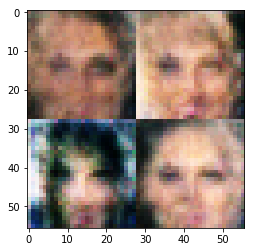

Epoch 0/1... Discriminator Loss: 1.3939... Generator Loss: 0.7333
Epoch 0/1... Discriminator Loss: 1.4776... Generator Loss: 0.5259
Epoch 0/1... Discriminator Loss: 1.5005... Generator Loss: 0.7303
Epoch 0/1... Discriminator Loss: 1.4234... Generator Loss: 0.7432
Epoch 0/1... Discriminator Loss: 1.3693... Generator Loss: 0.7456
Epoch 0/1... Discriminator Loss: 1.4046... Generator Loss: 0.8269
Epoch 0/1... Discriminator Loss: 1.5169... Generator Loss: 0.6075
Epoch 0/1... Discriminator Loss: 1.4062... Generator Loss: 0.8704
Epoch 0/1... Discriminator Loss: 1.3916... Generator Loss: 0.7676
Epoch 0/1... Discriminator Loss: 1.4253... Generator Loss: 0.6975


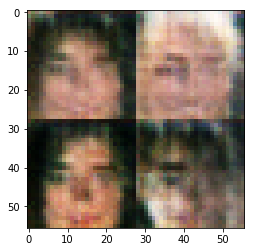

Epoch 0/1... Discriminator Loss: 1.5251... Generator Loss: 0.7089
Epoch 0/1... Discriminator Loss: 1.3679... Generator Loss: 0.6534
Epoch 0/1... Discriminator Loss: 1.3919... Generator Loss: 0.7206
Epoch 0/1... Discriminator Loss: 1.4163... Generator Loss: 0.7195
Epoch 0/1... Discriminator Loss: 1.3657... Generator Loss: 0.8242
Epoch 0/1... Discriminator Loss: 1.4013... Generator Loss: 0.7524
Epoch 0/1... Discriminator Loss: 1.6888... Generator Loss: 0.4542
Epoch 0/1... Discriminator Loss: 1.4314... Generator Loss: 0.6760
Epoch 0/1... Discriminator Loss: 1.3951... Generator Loss: 0.6371
Epoch 0/1... Discriminator Loss: 1.4627... Generator Loss: 0.6479


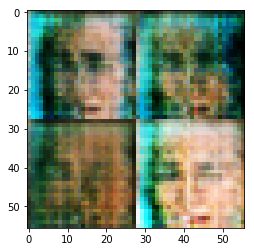

Epoch 0/1... Discriminator Loss: 1.3583... Generator Loss: 0.5075
Epoch 0/1... Discriminator Loss: 1.3946... Generator Loss: 0.7490
Epoch 0/1... Discriminator Loss: 1.3612... Generator Loss: 0.8017
Epoch 0/1... Discriminator Loss: 1.3860... Generator Loss: 0.7895
Epoch 0/1... Discriminator Loss: 1.4444... Generator Loss: 0.6466
Epoch 0/1... Discriminator Loss: 1.4137... Generator Loss: 0.6781
Epoch 0/1... Discriminator Loss: 1.4048... Generator Loss: 0.6379
Epoch 0/1... Discriminator Loss: 1.4341... Generator Loss: 0.7133
Epoch 0/1... Discriminator Loss: 1.4336... Generator Loss: 0.6556
Epoch 0/1... Discriminator Loss: 1.3747... Generator Loss: 0.7493


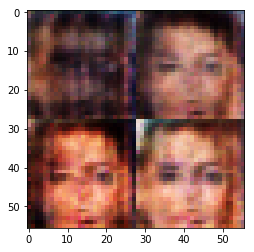

Epoch 0/1... Discriminator Loss: 1.3786... Generator Loss: 0.6920
Epoch 0/1... Discriminator Loss: 1.4159... Generator Loss: 0.8262
Epoch 0/1... Discriminator Loss: 1.4520... Generator Loss: 0.6932
Epoch 0/1... Discriminator Loss: 1.4348... Generator Loss: 0.6785
Epoch 0/1... Discriminator Loss: 1.4492... Generator Loss: 0.8464
Epoch 0/1... Discriminator Loss: 1.4004... Generator Loss: 0.7309
Epoch 0/1... Discriminator Loss: 1.3788... Generator Loss: 0.7701
Epoch 0/1... Discriminator Loss: 1.4399... Generator Loss: 0.7702
Epoch 0/1... Discriminator Loss: 1.3685... Generator Loss: 0.8073
Epoch 0/1... Discriminator Loss: 1.4114... Generator Loss: 0.7774


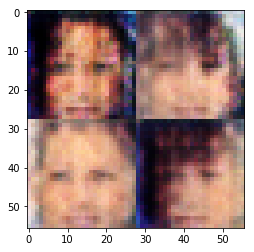

Epoch 0/1... Discriminator Loss: 1.3774... Generator Loss: 0.7533
Epoch 0/1... Discriminator Loss: 1.4328... Generator Loss: 0.6602
Epoch 0/1... Discriminator Loss: 1.3897... Generator Loss: 0.7611
Epoch 0/1... Discriminator Loss: 1.3457... Generator Loss: 0.8401
Epoch 0/1... Discriminator Loss: 1.4082... Generator Loss: 0.7076
Epoch 0/1... Discriminator Loss: 1.4106... Generator Loss: 0.7478
Epoch 0/1... Discriminator Loss: 1.3444... Generator Loss: 0.7561
Epoch 0/1... Discriminator Loss: 1.4061... Generator Loss: 0.8427
Epoch 0/1... Discriminator Loss: 1.4507... Generator Loss: 0.7531
Epoch 0/1... Discriminator Loss: 1.3924... Generator Loss: 0.7319


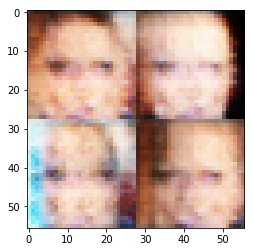

Epoch 0/1... Discriminator Loss: 1.4208... Generator Loss: 0.6827
Epoch 0/1... Discriminator Loss: 1.3910... Generator Loss: 0.7318
Epoch 0/1... Discriminator Loss: 1.3566... Generator Loss: 0.6987
Epoch 0/1... Discriminator Loss: 1.4039... Generator Loss: 0.7187
Epoch 0/1... Discriminator Loss: 1.3761... Generator Loss: 0.7283
Epoch 0/1... Discriminator Loss: 1.4241... Generator Loss: 0.8051
Epoch 0/1... Discriminator Loss: 1.4173... Generator Loss: 0.7429
Epoch 0/1... Discriminator Loss: 1.4551... Generator Loss: 0.6175
Epoch 0/1... Discriminator Loss: 1.3983... Generator Loss: 0.7735
Epoch 0/1... Discriminator Loss: 1.4146... Generator Loss: 0.7462


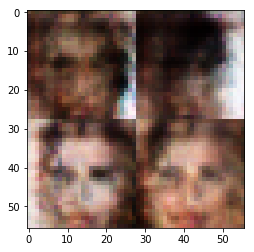

Epoch 0/1... Discriminator Loss: 1.4235... Generator Loss: 0.7317
Epoch 0/1... Discriminator Loss: 1.4624... Generator Loss: 0.7751
Epoch 0/1... Discriminator Loss: 1.3657... Generator Loss: 0.7475
Epoch 0/1... Discriminator Loss: 1.3786... Generator Loss: 0.6985
Epoch 0/1... Discriminator Loss: 1.3408... Generator Loss: 0.7969
Epoch 0/1... Discriminator Loss: 1.4336... Generator Loss: 0.7699
Epoch 0/1... Discriminator Loss: 1.4519... Generator Loss: 0.7393
Epoch 0/1... Discriminator Loss: 1.4128... Generator Loss: 0.7912
Epoch 0/1... Discriminator Loss: 1.3777... Generator Loss: 0.7177
Epoch 0/1... Discriminator Loss: 1.4935... Generator Loss: 0.5184


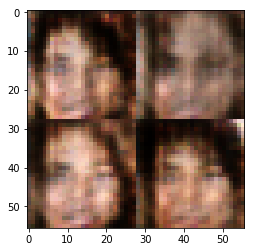

Epoch 0/1... Discriminator Loss: 1.4249... Generator Loss: 0.6503
Epoch 0/1... Discriminator Loss: 1.4082... Generator Loss: 0.8280
Epoch 0/1... Discriminator Loss: 1.3844... Generator Loss: 0.7598
Epoch 0/1... Discriminator Loss: 1.4182... Generator Loss: 0.8219
Epoch 0/1... Discriminator Loss: 1.4143... Generator Loss: 0.6893
Epoch 0/1... Discriminator Loss: 1.3957... Generator Loss: 0.7456
Epoch 0/1... Discriminator Loss: 1.3905... Generator Loss: 0.7624
Epoch 0/1... Discriminator Loss: 1.4012... Generator Loss: 0.7976
Epoch 0/1... Discriminator Loss: 1.3951... Generator Loss: 0.7808
Epoch 0/1... Discriminator Loss: 1.4215... Generator Loss: 0.7628


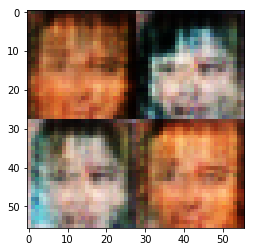

Epoch 0/1... Discriminator Loss: 1.3870... Generator Loss: 0.7298
Epoch 0/1... Discriminator Loss: 1.3831... Generator Loss: 0.7139
Epoch 0/1... Discriminator Loss: 1.4278... Generator Loss: 0.6672
Epoch 0/1... Discriminator Loss: 1.3433... Generator Loss: 0.7276
Epoch 0/1... Discriminator Loss: 1.4286... Generator Loss: 0.7407
Epoch 0/1... Discriminator Loss: 1.3795... Generator Loss: 0.6441
Epoch 0/1... Discriminator Loss: 1.3368... Generator Loss: 0.8005
Epoch 0/1... Discriminator Loss: 1.4183... Generator Loss: 0.6747
Epoch 0/1... Discriminator Loss: 1.4183... Generator Loss: 0.5526
Epoch 0/1... Discriminator Loss: 1.4704... Generator Loss: 0.9859


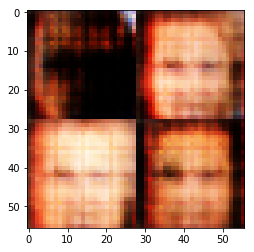

Epoch 0/1... Discriminator Loss: 1.4227... Generator Loss: 0.6523
Epoch 0/1... Discriminator Loss: 1.4073... Generator Loss: 0.7732
Epoch 0/1... Discriminator Loss: 1.4192... Generator Loss: 0.7559
Epoch 0/1... Discriminator Loss: 1.3872... Generator Loss: 0.7974
Epoch 0/1... Discriminator Loss: 1.3978... Generator Loss: 0.7739
Epoch 0/1... Discriminator Loss: 1.3775... Generator Loss: 0.7519
Epoch 0/1... Discriminator Loss: 1.4722... Generator Loss: 0.6939
Epoch 0/1... Discriminator Loss: 1.3718... Generator Loss: 0.7758
Epoch 0/1... Discriminator Loss: 1.5004... Generator Loss: 0.6546
Epoch 0/1... Discriminator Loss: 1.3924... Generator Loss: 0.7676


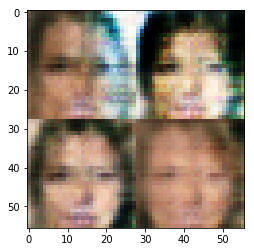

Epoch 0/1... Discriminator Loss: 1.3965... Generator Loss: 0.6671
Epoch 0/1... Discriminator Loss: 1.3423... Generator Loss: 0.6879
Epoch 0/1... Discriminator Loss: 1.3905... Generator Loss: 0.7781
Epoch 0/1... Discriminator Loss: 1.4690... Generator Loss: 0.7043
Epoch 0/1... Discriminator Loss: 1.4219... Generator Loss: 0.6575
Epoch 0/1... Discriminator Loss: 1.4115... Generator Loss: 0.6623
Epoch 0/1... Discriminator Loss: 1.4055... Generator Loss: 0.6783
Epoch 0/1... Discriminator Loss: 1.3777... Generator Loss: 0.7053
Epoch 0/1... Discriminator Loss: 1.3869... Generator Loss: 0.8160
Epoch 0/1... Discriminator Loss: 1.4248... Generator Loss: 0.7695


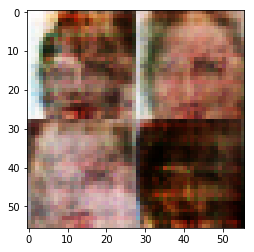

Epoch 0/1... Discriminator Loss: 1.4346... Generator Loss: 0.7686
Epoch 0/1... Discriminator Loss: 1.3736... Generator Loss: 0.8091
Epoch 0/1... Discriminator Loss: 1.4206... Generator Loss: 0.7073
Epoch 0/1... Discriminator Loss: 1.4085... Generator Loss: 0.6819
Epoch 0/1... Discriminator Loss: 1.3880... Generator Loss: 0.7834
Epoch 0/1... Discriminator Loss: 1.3927... Generator Loss: 0.7438
Epoch 0/1... Discriminator Loss: 1.4099... Generator Loss: 0.7517
Epoch 0/1... Discriminator Loss: 1.4049... Generator Loss: 0.6541
Epoch 0/1... Discriminator Loss: 1.3682... Generator Loss: 0.6857
Epoch 0/1... Discriminator Loss: 1.4295... Generator Loss: 0.6678


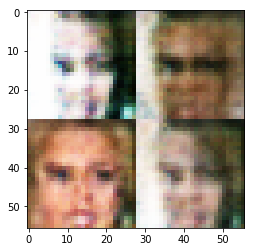

Epoch 0/1... Discriminator Loss: 1.4647... Generator Loss: 0.7888
Epoch 0/1... Discriminator Loss: 1.4080... Generator Loss: 0.7662
Epoch 0/1... Discriminator Loss: 1.4514... Generator Loss: 0.6908
Epoch 0/1... Discriminator Loss: 1.4007... Generator Loss: 0.7181
Epoch 0/1... Discriminator Loss: 1.4544... Generator Loss: 0.6255
Epoch 0/1... Discriminator Loss: 1.4113... Generator Loss: 0.7328
Epoch 0/1... Discriminator Loss: 1.4356... Generator Loss: 0.8097
Epoch 0/1... Discriminator Loss: 1.3712... Generator Loss: 0.7364
Epoch 0/1... Discriminator Loss: 1.4034... Generator Loss: 0.6620
Epoch 0/1... Discriminator Loss: 1.3897... Generator Loss: 0.7345


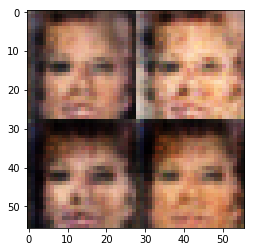

Epoch 0/1... Discriminator Loss: 1.4345... Generator Loss: 0.7985
Epoch 0/1... Discriminator Loss: 1.4000... Generator Loss: 0.6969
Epoch 0/1... Discriminator Loss: 1.4331... Generator Loss: 0.6661
Epoch 0/1... Discriminator Loss: 1.4109... Generator Loss: 0.7525
Epoch 0/1... Discriminator Loss: 1.4273... Generator Loss: 0.6999
Epoch 0/1... Discriminator Loss: 1.4171... Generator Loss: 0.7713
Epoch 0/1... Discriminator Loss: 1.4166... Generator Loss: 0.6638
Epoch 0/1... Discriminator Loss: 1.4071... Generator Loss: 0.6979
Epoch 0/1... Discriminator Loss: 1.4300... Generator Loss: 0.7482
Epoch 0/1... Discriminator Loss: 1.4269... Generator Loss: 0.7153


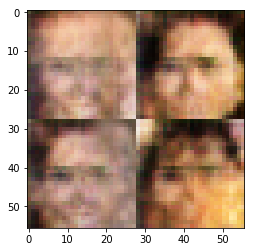

Epoch 0/1... Discriminator Loss: 1.3947... Generator Loss: 0.7487
Epoch 0/1... Discriminator Loss: 1.3904... Generator Loss: 0.7506
Epoch 0/1... Discriminator Loss: 1.4515... Generator Loss: 0.6258
Epoch 0/1... Discriminator Loss: 1.3854... Generator Loss: 0.7261
Epoch 0/1... Discriminator Loss: 1.3877... Generator Loss: 0.7658
Epoch 0/1... Discriminator Loss: 1.3784... Generator Loss: 0.7196
Epoch 0/1... Discriminator Loss: 1.3659... Generator Loss: 0.7676
Epoch 0/1... Discriminator Loss: 1.3470... Generator Loss: 0.7475
Epoch 0/1... Discriminator Loss: 1.4479... Generator Loss: 0.7624
Epoch 0/1... Discriminator Loss: 1.4172... Generator Loss: 0.6870


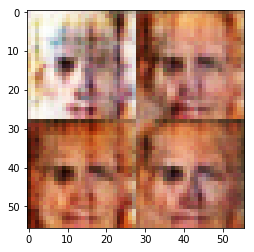

Epoch 0/1... Discriminator Loss: 1.3693... Generator Loss: 0.7735
Epoch 0/1... Discriminator Loss: 1.4385... Generator Loss: 0.6001
Epoch 0/1... Discriminator Loss: 1.4654... Generator Loss: 0.7083
Epoch 0/1... Discriminator Loss: 1.3430... Generator Loss: 0.7897
Epoch 0/1... Discriminator Loss: 1.2369... Generator Loss: 0.8261
Epoch 0/1... Discriminator Loss: 1.3785... Generator Loss: 0.7372
Epoch 0/1... Discriminator Loss: 1.4608... Generator Loss: 0.6860
Epoch 0/1... Discriminator Loss: 1.6694... Generator Loss: 0.4496
Epoch 0/1... Discriminator Loss: 1.3698... Generator Loss: 0.7174
Epoch 0/1... Discriminator Loss: 1.5850... Generator Loss: 0.6924


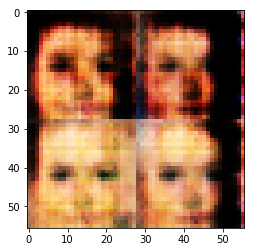

Epoch 0/1... Discriminator Loss: 1.3202... Generator Loss: 0.7092
Epoch 0/1... Discriminator Loss: 1.3778... Generator Loss: 0.8254
Epoch 0/1... Discriminator Loss: 1.4328... Generator Loss: 0.7084
Epoch 0/1... Discriminator Loss: 1.3891... Generator Loss: 0.7052
Epoch 0/1... Discriminator Loss: 1.3326... Generator Loss: 0.7165
Epoch 0/1... Discriminator Loss: 1.4225... Generator Loss: 0.6629
Epoch 0/1... Discriminator Loss: 1.4498... Generator Loss: 0.7054
Epoch 0/1... Discriminator Loss: 1.4083... Generator Loss: 0.6874
Epoch 0/1... Discriminator Loss: 1.3741... Generator Loss: 0.8413
Epoch 0/1... Discriminator Loss: 1.3816... Generator Loss: 0.7791


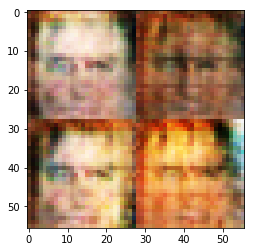

Epoch 0/1... Discriminator Loss: 1.3990... Generator Loss: 0.6878
Epoch 0/1... Discriminator Loss: 1.4098... Generator Loss: 0.6684
Epoch 0/1... Discriminator Loss: 1.3869... Generator Loss: 0.7189
Epoch 0/1... Discriminator Loss: 1.3989... Generator Loss: 0.8127
Epoch 0/1... Discriminator Loss: 1.4233... Generator Loss: 0.6972
Epoch 0/1... Discriminator Loss: 1.3968... Generator Loss: 0.7213
Epoch 0/1... Discriminator Loss: 1.3666... Generator Loss: 0.7562
Epoch 0/1... Discriminator Loss: 1.3689... Generator Loss: 0.7246
Epoch 0/1... Discriminator Loss: 1.3922... Generator Loss: 0.7740
Epoch 0/1... Discriminator Loss: 1.4446... Generator Loss: 0.7093


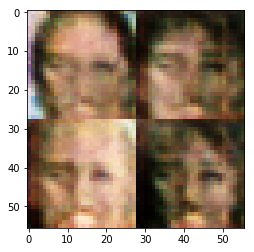

Epoch 0/1... Discriminator Loss: 1.4150... Generator Loss: 0.7418
Epoch 0/1... Discriminator Loss: 1.4031... Generator Loss: 0.6946
Epoch 0/1... Discriminator Loss: 1.4065... Generator Loss: 0.7290
Epoch 0/1... Discriminator Loss: 1.4473... Generator Loss: 0.6525
Epoch 0/1... Discriminator Loss: 1.4403... Generator Loss: 0.7238
Epoch 0/1... Discriminator Loss: 1.4065... Generator Loss: 0.6742
Epoch 0/1... Discriminator Loss: 1.3467... Generator Loss: 0.7669
Epoch 0/1... Discriminator Loss: 1.4079... Generator Loss: 0.6822
Epoch 0/1... Discriminator Loss: 1.3418... Generator Loss: 0.7950
Epoch 0/1... Discriminator Loss: 1.3923... Generator Loss: 0.7466


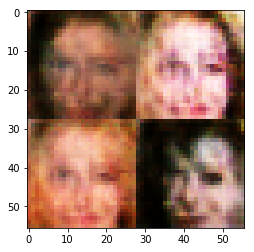

Epoch 0/1... Discriminator Loss: 1.3940... Generator Loss: 0.7373
Epoch 0/1... Discriminator Loss: 1.3974... Generator Loss: 0.7656
Epoch 0/1... Discriminator Loss: 1.4046... Generator Loss: 0.7030
Epoch 0/1... Discriminator Loss: 1.4065... Generator Loss: 0.6992
Epoch 0/1... Discriminator Loss: 1.3685... Generator Loss: 0.6832
Epoch 0/1... Discriminator Loss: 1.4145... Generator Loss: 0.7792
Epoch 0/1... Discriminator Loss: 1.3776... Generator Loss: 0.7810
Epoch 0/1... Discriminator Loss: 1.4956... Generator Loss: 0.6650
Epoch 0/1... Discriminator Loss: 1.3600... Generator Loss: 0.6865
Epoch 0/1... Discriminator Loss: 1.3651... Generator Loss: 0.7656


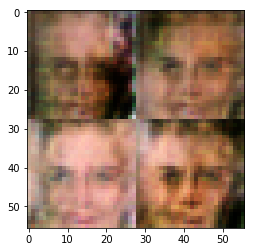

Epoch 0/1... Discriminator Loss: 1.4429... Generator Loss: 0.7031
Epoch 0/1... Discriminator Loss: 1.3510... Generator Loss: 0.7672
Epoch 0/1... Discriminator Loss: 1.3982... Generator Loss: 0.7780
Epoch 0/1... Discriminator Loss: 1.4245... Generator Loss: 0.7107
Epoch 0/1... Discriminator Loss: 1.4026... Generator Loss: 0.7170
Epoch 0/1... Discriminator Loss: 1.3464... Generator Loss: 0.7507
Epoch 0/1... Discriminator Loss: 1.3709... Generator Loss: 0.7555
Epoch 0/1... Discriminator Loss: 1.4057... Generator Loss: 0.7513
Epoch 0/1... Discriminator Loss: 1.4356... Generator Loss: 0.7316
Epoch 0/1... Discriminator Loss: 1.3818... Generator Loss: 0.7771


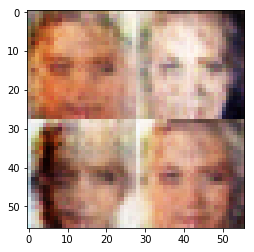

Epoch 0/1... Discriminator Loss: 1.4075... Generator Loss: 0.7363
Epoch 0/1... Discriminator Loss: 1.3825... Generator Loss: 0.7534
Epoch 0/1... Discriminator Loss: 1.4100... Generator Loss: 0.7371
Epoch 0/1... Discriminator Loss: 1.4345... Generator Loss: 0.7245
Epoch 0/1... Discriminator Loss: 1.3916... Generator Loss: 0.7421
Epoch 0/1... Discriminator Loss: 1.4291... Generator Loss: 0.6544
Epoch 0/1... Discriminator Loss: 1.3736... Generator Loss: 0.7397
Epoch 0/1... Discriminator Loss: 1.4047... Generator Loss: 0.7144
Epoch 0/1... Discriminator Loss: 1.4237... Generator Loss: 0.7446
Epoch 0/1... Discriminator Loss: 1.4165... Generator Loss: 0.7338


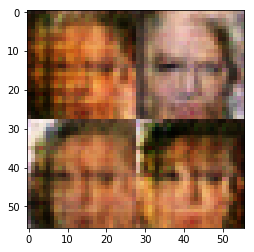

Epoch 0/1... Discriminator Loss: 1.4088... Generator Loss: 0.7291
Epoch 0/1... Discriminator Loss: 1.3863... Generator Loss: 0.7378
Epoch 0/1... Discriminator Loss: 1.3838... Generator Loss: 0.7151
Epoch 0/1... Discriminator Loss: 1.3807... Generator Loss: 0.7202
Epoch 0/1... Discriminator Loss: 1.4360... Generator Loss: 0.6650
Epoch 0/1... Discriminator Loss: 1.3703... Generator Loss: 0.7787
Epoch 0/1... Discriminator Loss: 1.3946... Generator Loss: 0.6965
Epoch 0/1... Discriminator Loss: 1.4033... Generator Loss: 0.7512
Epoch 0/1... Discriminator Loss: 1.4380... Generator Loss: 0.6976
Epoch 0/1... Discriminator Loss: 1.4337... Generator Loss: 0.7256


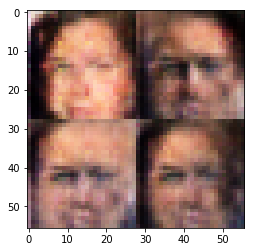

Epoch 0/1... Discriminator Loss: 1.4072... Generator Loss: 0.7065
Epoch 0/1... Discriminator Loss: 1.4041... Generator Loss: 0.7100
Epoch 0/1... Discriminator Loss: 1.4461... Generator Loss: 0.6599
Epoch 0/1... Discriminator Loss: 1.3901... Generator Loss: 0.7459
Epoch 0/1... Discriminator Loss: 1.3957... Generator Loss: 0.7050
Epoch 0/1... Discriminator Loss: 1.4338... Generator Loss: 0.7382
Epoch 0/1... Discriminator Loss: 1.3892... Generator Loss: 0.7706
Epoch 0/1... Discriminator Loss: 1.4011... Generator Loss: 0.7383
Epoch 0/1... Discriminator Loss: 1.3857... Generator Loss: 0.7637
Epoch 0/1... Discriminator Loss: 1.3831... Generator Loss: 0.7409


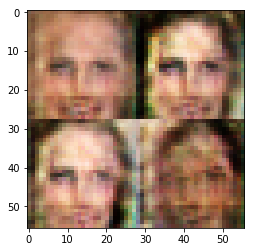

Epoch 0/1... Discriminator Loss: 1.3928... Generator Loss: 0.7619
Epoch 0/1... Discriminator Loss: 1.4195... Generator Loss: 0.7245
Epoch 0/1... Discriminator Loss: 1.4378... Generator Loss: 0.7026
Epoch 0/1... Discriminator Loss: 1.3887... Generator Loss: 0.7379
Epoch 0/1... Discriminator Loss: 1.3658... Generator Loss: 0.7925
Epoch 0/1... Discriminator Loss: 1.3520... Generator Loss: 0.6856
Epoch 0/1... Discriminator Loss: 1.3919... Generator Loss: 0.7353
Epoch 0/1... Discriminator Loss: 1.4019... Generator Loss: 0.7612
Epoch 0/1... Discriminator Loss: 1.3516... Generator Loss: 0.7108
Epoch 0/1... Discriminator Loss: 1.4414... Generator Loss: 0.7681


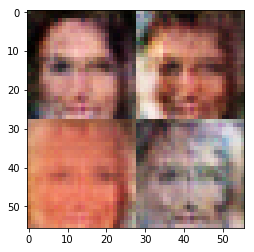

Epoch 0/1... Discriminator Loss: 1.3586... Generator Loss: 0.7571
Epoch 0/1... Discriminator Loss: 1.3866... Generator Loss: 0.7451
Epoch 0/1... Discriminator Loss: 1.4016... Generator Loss: 0.7468
Epoch 0/1... Discriminator Loss: 1.4151... Generator Loss: 0.7134
Epoch 0/1... Discriminator Loss: 1.4288... Generator Loss: 0.6486
Epoch 0/1... Discriminator Loss: 1.3554... Generator Loss: 0.7727
Epoch 0/1... Discriminator Loss: 1.4324... Generator Loss: 0.7391
Epoch 0/1... Discriminator Loss: 1.3687... Generator Loss: 0.7560
Epoch 0/1... Discriminator Loss: 1.4132... Generator Loss: 0.7351
Epoch 0/1... Discriminator Loss: 1.4109... Generator Loss: 0.7082


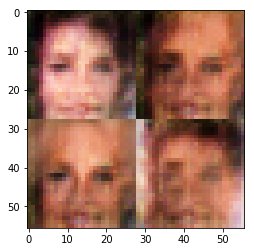

Epoch 0/1... Discriminator Loss: 1.3815... Generator Loss: 0.7557
Epoch 0/1... Discriminator Loss: 1.4107... Generator Loss: 0.7206
Epoch 0/1... Discriminator Loss: 1.4003... Generator Loss: 0.7080
Epoch 0/1... Discriminator Loss: 1.3630... Generator Loss: 0.7200
Epoch 0/1... Discriminator Loss: 1.4042... Generator Loss: 0.7321
Epoch 0/1... Discriminator Loss: 1.3950... Generator Loss: 0.7266
Epoch 0/1... Discriminator Loss: 1.3674... Generator Loss: 0.7542
Epoch 0/1... Discriminator Loss: 1.3830... Generator Loss: 0.7729
Epoch 0/1... Discriminator Loss: 1.4074... Generator Loss: 0.7134
Epoch 0/1... Discriminator Loss: 1.3686... Generator Loss: 0.7157


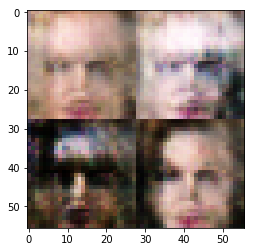

Epoch 0/1... Discriminator Loss: 1.3899... Generator Loss: 0.7281
Epoch 0/1... Discriminator Loss: 1.4047... Generator Loss: 0.7620
Epoch 0/1... Discriminator Loss: 1.3490... Generator Loss: 0.7436
Epoch 0/1... Discriminator Loss: 1.3713... Generator Loss: 0.7692
Epoch 0/1... Discriminator Loss: 1.3908... Generator Loss: 0.7092
Epoch 0/1... Discriminator Loss: 1.3660... Generator Loss: 0.7272
Epoch 0/1... Discriminator Loss: 1.3805... Generator Loss: 0.7360
Epoch 0/1... Discriminator Loss: 1.3787... Generator Loss: 0.7640
Epoch 0/1... Discriminator Loss: 1.4233... Generator Loss: 0.6965
Epoch 0/1... Discriminator Loss: 1.4247... Generator Loss: 0.7319


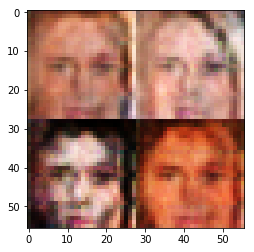

Epoch 0/1... Discriminator Loss: 1.3868... Generator Loss: 0.7619
Epoch 0/1... Discriminator Loss: 1.3976... Generator Loss: 0.7462
Epoch 0/1... Discriminator Loss: 1.4072... Generator Loss: 0.7613
Epoch 0/1... Discriminator Loss: 1.3885... Generator Loss: 0.7333
Epoch 0/1... Discriminator Loss: 1.3993... Generator Loss: 0.7669
Epoch 0/1... Discriminator Loss: 1.3768... Generator Loss: 0.6965
Epoch 0/1... Discriminator Loss: 1.4237... Generator Loss: 0.7186
Epoch 0/1... Discriminator Loss: 1.3951... Generator Loss: 0.7797
Epoch 0/1... Discriminator Loss: 1.3558... Generator Loss: 0.7451
Epoch 0/1... Discriminator Loss: 1.3937... Generator Loss: 0.7877


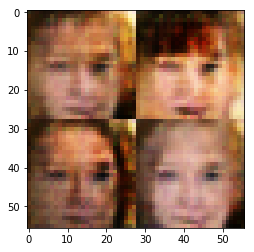

Epoch 0/1... Discriminator Loss: 1.3827... Generator Loss: 0.7424
Epoch 0/1... Discriminator Loss: 1.3764... Generator Loss: 0.7217
Epoch 0/1... Discriminator Loss: 1.3469... Generator Loss: 0.7304
Epoch 0/1... Discriminator Loss: 1.3831... Generator Loss: 0.7307
Epoch 0/1... Discriminator Loss: 1.4287... Generator Loss: 0.6782
Epoch 0/1... Discriminator Loss: 1.3837... Generator Loss: 0.7454
Epoch 0/1... Discriminator Loss: 1.3879... Generator Loss: 0.7588
Epoch 0/1... Discriminator Loss: 1.3966... Generator Loss: 0.6882
Epoch 0/1... Discriminator Loss: 1.4549... Generator Loss: 0.7262
Epoch 0/1... Discriminator Loss: 1.3877... Generator Loss: 0.7232


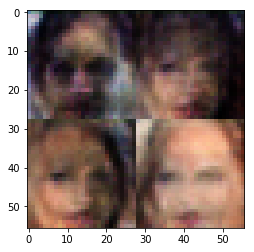

Epoch 0/1... Discriminator Loss: 1.4098... Generator Loss: 0.7249
Epoch 0/1... Discriminator Loss: 1.4282... Generator Loss: 0.6780
Epoch 0/1... Discriminator Loss: 1.3776... Generator Loss: 0.7508
Epoch 0/1... Discriminator Loss: 1.3834... Generator Loss: 0.7069
Epoch 0/1... Discriminator Loss: 1.4058... Generator Loss: 0.7147
Epoch 0/1... Discriminator Loss: 1.3695... Generator Loss: 0.7935
Epoch 0/1... Discriminator Loss: 1.4109... Generator Loss: 0.7563
Epoch 0/1... Discriminator Loss: 1.4115... Generator Loss: 0.6857
Epoch 0/1... Discriminator Loss: 1.3899... Generator Loss: 0.7468
Epoch 0/1... Discriminator Loss: 1.3707... Generator Loss: 0.7492


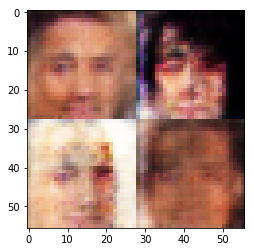

Epoch 0/1... Discriminator Loss: 1.3982... Generator Loss: 0.7384
Epoch 0/1... Discriminator Loss: 1.3927... Generator Loss: 0.7376
Epoch 0/1... Discriminator Loss: 1.3793... Generator Loss: 0.7648
Epoch 0/1... Discriminator Loss: 1.3935... Generator Loss: 0.7114
Epoch 0/1... Discriminator Loss: 1.4008... Generator Loss: 0.7160
Epoch 0/1... Discriminator Loss: 1.3702... Generator Loss: 0.7592
Epoch 0/1... Discriminator Loss: 1.3970... Generator Loss: 0.7340
Epoch 0/1... Discriminator Loss: 1.3900... Generator Loss: 0.7297
Epoch 0/1... Discriminator Loss: 1.4418... Generator Loss: 0.6891
Epoch 0/1... Discriminator Loss: 1.3761... Generator Loss: 0.7519


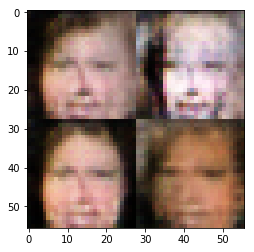

Epoch 0/1... Discriminator Loss: 1.3768... Generator Loss: 0.7422
Epoch 0/1... Discriminator Loss: 1.3568... Generator Loss: 0.7636
Epoch 0/1... Discriminator Loss: 1.3916... Generator Loss: 0.7222
Epoch 0/1... Discriminator Loss: 1.3948... Generator Loss: 0.6957
Epoch 0/1... Discriminator Loss: 1.3826... Generator Loss: 0.7478
Epoch 0/1... Discriminator Loss: 1.4121... Generator Loss: 0.7497
Epoch 0/1... Discriminator Loss: 1.3931... Generator Loss: 0.7417
Epoch 0/1... Discriminator Loss: 1.3825... Generator Loss: 0.7208
Epoch 0/1... Discriminator Loss: 1.3847... Generator Loss: 0.7492
Epoch 0/1... Discriminator Loss: 1.3976... Generator Loss: 0.7381


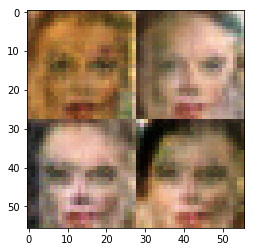

Epoch 0/1... Discriminator Loss: 1.3956... Generator Loss: 0.7356
Epoch 0/1... Discriminator Loss: 1.3763... Generator Loss: 0.7687
Epoch 0/1... Discriminator Loss: 1.3748... Generator Loss: 0.7398
Epoch 0/1... Discriminator Loss: 1.3882... Generator Loss: 0.7373
Epoch 0/1... Discriminator Loss: 1.4548... Generator Loss: 0.6768
Epoch 0/1... Discriminator Loss: 1.3981... Generator Loss: 0.7126
Epoch 0/1... Discriminator Loss: 1.3904... Generator Loss: 0.7459
Epoch 0/1... Discriminator Loss: 1.3313... Generator Loss: 0.7419
Epoch 0/1... Discriminator Loss: 1.3967... Generator Loss: 0.7494
Epoch 0/1... Discriminator Loss: 1.3809... Generator Loss: 0.7643


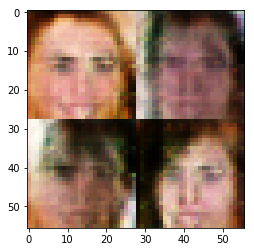

Epoch 0/1... Discriminator Loss: 1.3658... Generator Loss: 0.7590
Epoch 0/1... Discriminator Loss: 1.4210... Generator Loss: 0.7603
Epoch 0/1... Discriminator Loss: 1.3876... Generator Loss: 0.7583
Epoch 0/1... Discriminator Loss: 1.4063... Generator Loss: 0.6918
Epoch 0/1... Discriminator Loss: 1.3718... Generator Loss: 0.6859
Epoch 0/1... Discriminator Loss: 1.4313... Generator Loss: 0.7355
Epoch 0/1... Discriminator Loss: 1.3950... Generator Loss: 0.6970
Epoch 0/1... Discriminator Loss: 1.4078... Generator Loss: 0.7162
Epoch 0/1... Discriminator Loss: 1.3647... Generator Loss: 0.7050
Epoch 0/1... Discriminator Loss: 1.4371... Generator Loss: 0.7214


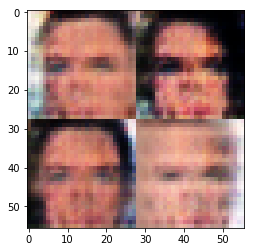

Epoch 0/1... Discriminator Loss: 1.3948... Generator Loss: 0.7978
Epoch 0/1... Discriminator Loss: 1.3437... Generator Loss: 0.6930
Epoch 0/1... Discriminator Loss: 1.3697... Generator Loss: 0.7716
Epoch 0/1... Discriminator Loss: 1.4112... Generator Loss: 0.7420
Epoch 0/1... Discriminator Loss: 1.3923... Generator Loss: 0.7578
Epoch 0/1... Discriminator Loss: 1.3315... Generator Loss: 0.7227
Epoch 0/1... Discriminator Loss: 1.4421... Generator Loss: 0.7318
Epoch 0/1... Discriminator Loss: 1.4478... Generator Loss: 0.6527
Epoch 0/1... Discriminator Loss: 1.3877... Generator Loss: 0.7743
Epoch 0/1... Discriminator Loss: 1.3679... Generator Loss: 0.7575


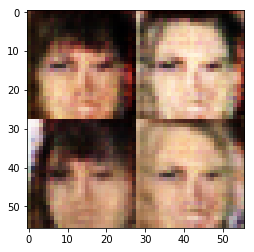

Epoch 0/1... Discriminator Loss: 1.3547... Generator Loss: 0.7709
Epoch 0/1... Discriminator Loss: 1.3877... Generator Loss: 0.7543
Epoch 0/1... Discriminator Loss: 1.4289... Generator Loss: 0.7515
Epoch 0/1... Discriminator Loss: 1.3993... Generator Loss: 0.7259
Epoch 0/1... Discriminator Loss: 1.3877... Generator Loss: 0.7620
Epoch 0/1... Discriminator Loss: 1.3854... Generator Loss: 0.7726
Epoch 0/1... Discriminator Loss: 1.4336... Generator Loss: 0.6615
Epoch 0/1... Discriminator Loss: 1.4080... Generator Loss: 0.7578
Epoch 0/1... Discriminator Loss: 1.4081... Generator Loss: 0.7183
Epoch 0/1... Discriminator Loss: 1.3923... Generator Loss: 0.6428


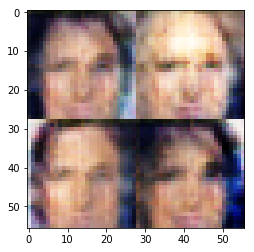

Epoch 0/1... Discriminator Loss: 1.3721... Generator Loss: 0.7375
Epoch 0/1... Discriminator Loss: 1.4032... Generator Loss: 0.7523
Epoch 0/1... Discriminator Loss: 1.3637... Generator Loss: 0.7384
Epoch 0/1... Discriminator Loss: 1.3789... Generator Loss: 0.7112
Epoch 0/1... Discriminator Loss: 1.3798... Generator Loss: 0.7533
Epoch 0/1... Discriminator Loss: 1.4148... Generator Loss: 0.6819
Epoch 0/1... Discriminator Loss: 1.3838... Generator Loss: 0.7637
Epoch 0/1... Discriminator Loss: 1.3878... Generator Loss: 0.7452
Epoch 0/1... Discriminator Loss: 1.4005... Generator Loss: 0.7519
Epoch 0/1... Discriminator Loss: 1.3954... Generator Loss: 0.7360


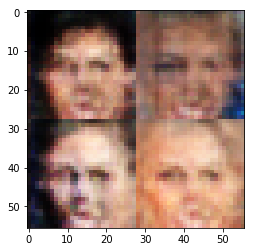

Epoch 0/1... Discriminator Loss: 1.3956... Generator Loss: 0.7342
Epoch 0/1... Discriminator Loss: 1.3943... Generator Loss: 0.7411
Epoch 0/1... Discriminator Loss: 1.4036... Generator Loss: 0.7340
Epoch 0/1... Discriminator Loss: 1.3731... Generator Loss: 0.7174
Epoch 0/1... Discriminator Loss: 1.3572... Generator Loss: 0.7533
Epoch 0/1... Discriminator Loss: 1.3956... Generator Loss: 0.7692
Epoch 0/1... Discriminator Loss: 1.3818... Generator Loss: 0.7531
Epoch 0/1... Discriminator Loss: 1.3726... Generator Loss: 0.7397
Epoch 0/1... Discriminator Loss: 1.3655... Generator Loss: 0.7207
Epoch 0/1... Discriminator Loss: 1.4092... Generator Loss: 0.7591


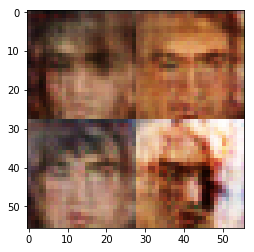

Epoch 0/1... Discriminator Loss: 1.3943... Generator Loss: 0.7278
Epoch 0/1... Discriminator Loss: 1.3711... Generator Loss: 0.7483
Epoch 0/1... Discriminator Loss: 1.4199... Generator Loss: 0.7071
Epoch 0/1... Discriminator Loss: 1.3614... Generator Loss: 0.7361
Epoch 0/1... Discriminator Loss: 1.3848... Generator Loss: 0.7400
Epoch 0/1... Discriminator Loss: 1.4054... Generator Loss: 0.7621
Epoch 0/1... Discriminator Loss: 1.3668... Generator Loss: 0.7589
Epoch 0/1... Discriminator Loss: 1.3796... Generator Loss: 0.7214
Epoch 0/1... Discriminator Loss: 1.4390... Generator Loss: 0.7011
Epoch 0/1... Discriminator Loss: 1.4043... Generator Loss: 0.7561


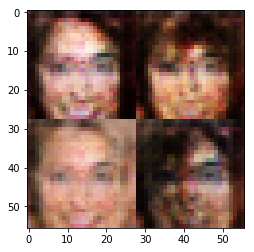

Epoch 0/1... Discriminator Loss: 1.3602... Generator Loss: 0.7587
Epoch 0/1... Discriminator Loss: 1.3822... Generator Loss: 0.7298
Epoch 0/1... Discriminator Loss: 1.3933... Generator Loss: 0.7428
Epoch 0/1... Discriminator Loss: 1.4069... Generator Loss: 0.7381
Epoch 0/1... Discriminator Loss: 1.3930... Generator Loss: 0.7048
Epoch 0/1... Discriminator Loss: 1.3725... Generator Loss: 0.7256
Epoch 0/1... Discriminator Loss: 1.4007... Generator Loss: 0.6476
Epoch 0/1... Discriminator Loss: 1.3988... Generator Loss: 0.7513
Epoch 0/1... Discriminator Loss: 1.3901... Generator Loss: 0.7603
Epoch 0/1... Discriminator Loss: 1.3646... Generator Loss: 0.7104


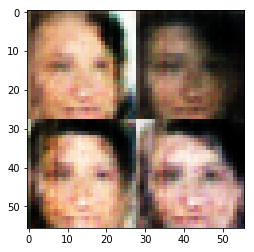

Epoch 0/1... Discriminator Loss: 1.3648... Generator Loss: 0.8165
Epoch 0/1... Discriminator Loss: 1.3721... Generator Loss: 0.7512
Epoch 0/1... Discriminator Loss: 1.3864... Generator Loss: 0.7305
Epoch 0/1... Discriminator Loss: 1.4040... Generator Loss: 0.7108
Epoch 0/1... Discriminator Loss: 1.3993... Generator Loss: 0.7436
Epoch 0/1... Discriminator Loss: 1.3909... Generator Loss: 0.7307
Epoch 0/1... Discriminator Loss: 1.4096... Generator Loss: 0.6822
Epoch 0/1... Discriminator Loss: 1.4010... Generator Loss: 0.7541
Epoch 0/1... Discriminator Loss: 1.4157... Generator Loss: 0.7785
Epoch 0/1... Discriminator Loss: 1.3925... Generator Loss: 0.7541


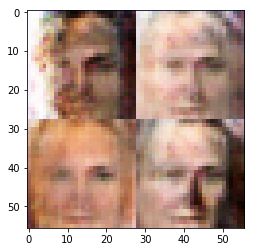

Epoch 0/1... Discriminator Loss: 1.4143... Generator Loss: 0.7001
Epoch 0/1... Discriminator Loss: 1.3456... Generator Loss: 0.7873
Epoch 0/1... Discriminator Loss: 1.4379... Generator Loss: 0.6696
The final generation is :


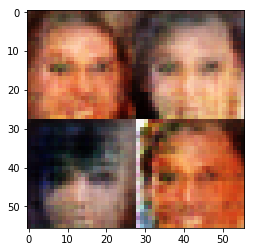

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0009
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.